In [1]:
import torch
import meshzoo
from torchfem import Shell
import matplotlib.pyplot as plt

In [2]:
# Constants
E = 10000
nu = 0.3
L = 100.0
t = 1.0
F = -1.0

# Define plate
X = torch.linspace(0.0, L, 9)
Y = torch.linspace(0.0, L, 9)
points, cells = meshzoo.rectangle_tri(X, Y, variant="zigzag")
N = len(points)
nodes = torch.hstack([torch.tensor(points, dtype=torch.float32), torch.zeros((N, 1))])
elements = cells.tolist()

# Boundaries
top = nodes[:, 1] > 99.9
bottom = nodes[:, 1] < 0.01
left = nodes[:, 0] < 0.01
right = nodes[:, 0] > 99.9

# Boundary conditions
forces = torch.zeros((N, 6))
forces[0, 2] = F
displacements = torch.zeros((N, 6))
constraints = torch.zeros((N, 6), dtype=bool)
constraints[top] = True
constraints[right] = True
constraints[left, 0] = True
constraints[left, 4] = True
constraints[left, 5] = True
constraints[bottom, 1] = True
constraints[bottom, 3] = True
constraints[bottom, 5] = True

# Thickness
thickness = t * torch.ones(len(elements))

# Create Shell model
plate = Shell(nodes, elements, forces, displacements, constraints, thickness, E, nu)

In [3]:
r = torch.cdist(plate.nodes, plate.nodes)
epsilon = 0.05
phi = torch.exp(-((epsilon * r) ** 2))


def objective_function(z):
    plate.nodes = torch.hstack([torch.tensor(points, dtype=torch.float32), phi @ z])
    plate.update_local_nodes()
    u, f = plate.solve()
    return torch.inner(u.ravel(), f.ravel())

In [4]:
z = torch.zeros((N, 1), requires_grad=True)

optimizer = torch.optim.Adam([z], lr=0.1)

energies = []

for i in range(100):
    optimizer.zero_grad()
    objective = objective_function(z)
    energies.append(objective.detach().item())
    objective.backward()
    optimizer.step()

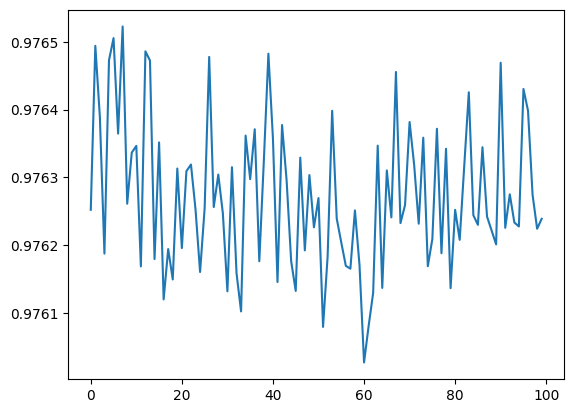

In [5]:
plt.plot(energies)

In [6]:
u, f = plate.solve()
plate.plot(node_property={"u": torch.linalg.norm(u[:, 0:3], dim=1)})

Widget(value="<iframe src='http://localhost:53688/index.html?ui=P_0x29f7d3310_1&reconnect=auto' style='width: …